## По материалам https://www.kaggle.com/witwitchayakarn/u-net-with-pytorch


In [35]:
import os
import random
import shutil

from multiprocessing.dummy import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split
# import sklearn.external.joblib as extjoblib
import joblib

from skimage.morphology import binary_opening, disk, label

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms

In [36]:
# os.environ['KAGGLE_USERNAME'] = "" # username from the json file
# os.environ['KAGGLE_KEY'] = ""

In [37]:
# !kaggle competitions download -c airbus-ship-detection

In [38]:
%matplotlib inline

In [39]:
train_dpath = 'D:/Backup/Курс Нетология/Глубокое обучение/10 CV 2/dll_hw_9_CV_2/data/imgs/'

anno_fpath = 'D:/Backup/Курс Нетология/Глубокое обучение/10 CV 2/dll_hw_9_CV_2/data/rle_masks.csv'

excluded_filenames = ['6384c3e78.jpg', ]
original_img_size = (768, 768)

In [40]:
# !unzip train_ship_segmentations_v2.csv.zip

In [41]:
annos = pd.read_csv(anno_fpath)
annos = annos[~annos['ImageId'].isin(excluded_filenames)]

In [42]:
annos.head()

,ImageId,EncodedPixels
0,Img_0.jpg,54949 1 55455 1 55709 17 56217 13 56342 1 5647...
1,Img_1.jpg,59516 1 60276 17 61041 23 61806 29 62572 33 63...
2,Img_2.jpg,72420 1 73181 15 73946 21 74712 25 75478 29 76...
3,Img_3.jpg,50342 1 51102 17 51866 25 52631 31 53397 35 54...
4,Img_4.jpg,54780 1 55539 19 56303 27 57068 33 57833 39 58...


In [43]:
annos['EncodedPixels_flag'] = annos['EncodedPixels'].map(lambda v: 1 if isinstance(v, str) else 0)

In [44]:
annos.head()

,ImageId,EncodedPixels,EncodedPixels_flag
0,Img_0.jpg,54949 1 55455 1 55709 17 56217 13 56342 1 5647...,1
1,Img_1.jpg,59516 1 60276 17 61041 23 61806 29 62572 33 63...,1
2,Img_2.jpg,72420 1 73181 15 73946 21 74712 25 75478 29 76...,1
3,Img_3.jpg,50342 1 51102 17 51866 25 52631 31 53397 35 54...,1
4,Img_4.jpg,54780 1 55539 19 56303 27 57068 33 57833 39 58...,1


In [45]:
imgs = annos.groupby('ImageId').agg({'EncodedPixels_flag': 'sum'}).reset_index().rename(columns={'EncodedPixels_flag': 'ships'})

In [46]:
len(imgs)

2048

In [47]:
print(len(imgs[imgs['ships'] > 0]))

2048


In [48]:
imgs_w_ships = imgs[imgs['ships'] > 0]
# imgs_wo_ships = imgs[imgs['ships'] == 0].sample(20000, random_state=69278)
imgs_wo_ships = imgs[imgs['ships'] == 0]

selected_imgs = pd.concat((imgs_w_ships, imgs_wo_ships))
selected_imgs['has_ship'] = selected_imgs['ships'] > 0

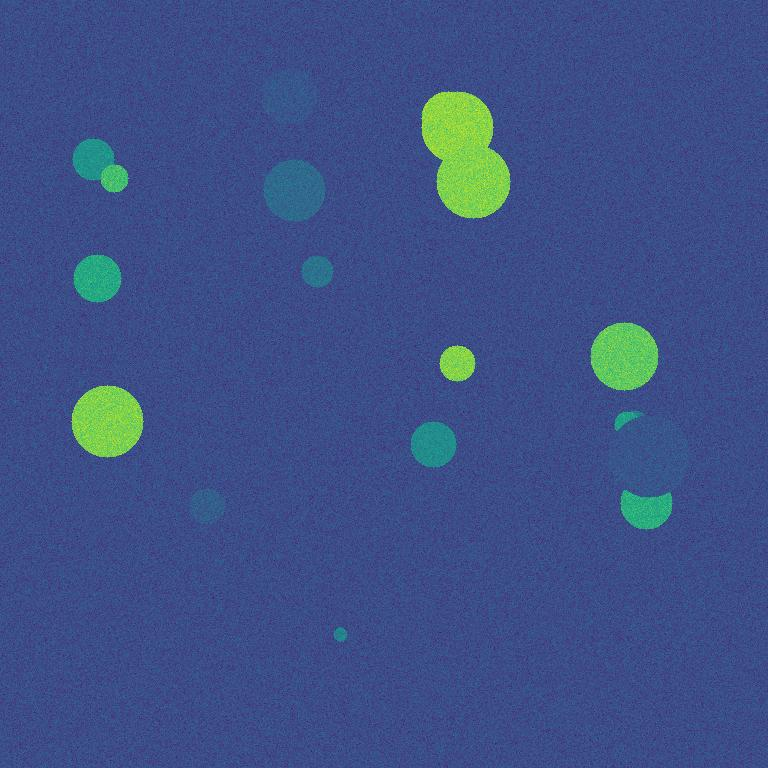

In [49]:
Image.open(train_dpath + imgs_w_ships.iloc[0]['ImageId'])

In [50]:
train_imgs, val_imgs = train_test_split(selected_imgs, test_size=0.15, stratify=selected_imgs['has_ship'], random_state=69278)

train_fnames = train_imgs['ImageId'].values
val_fnames = val_imgs['ImageId'].values

In [51]:
_, train_fnames = train_test_split(train_fnames, test_size=0.1, random_state=69278)
_, val_fnames = train_test_split(val_fnames, test_size=0.1, random_state=69278)

In [52]:
print("Train ", len(train_fnames), "val", len(val_fnames))

Train  174 val 31


In [53]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ends = starts + lengths
    im = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        im[lo:hi] = 1
    return im.reshape(shape).T

def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    runs[::2] -= 1
    return ' '.join(str(x) for x in runs)

In [54]:
class ImgDataset(Dataset):

    def __init__(self,
                 img_dpath,
                 img_fnames,
                 img_transform,
                 mask_encodings=None,
                 mask_size=None,
                 mask_transform=None):
        self.img_dpath = img_dpath
        self.img_fnames = img_fnames
        self.img_transform = img_transform

        self.mask_encodings = mask_encodings
        self.mask_size = mask_size
        self.mask_transform = mask_transform

    def __getitem__(self, i):
        # https://github.com/pytorch/vision/issues/9#issuecomment-304224800
        seed = np.random.randint(2147483647)

        fname = self.img_fnames[i]
        fpath = os.path.join(self.img_dpath, fname)
        img = Image.open(fpath)
        if self.img_transform is not None:
            random.seed(seed)
            img = self.img_transform(img)

        if self.mask_encodings is None:
            return img, fname

        if self.mask_size is None or self.mask_transform is None:
            raise ValueError('If mask_dpath is not None, mask_size and mask_transform must not be None.')

        mask = np.zeros(self.mask_size, dtype=np.uint8)
        if self.mask_encodings[fname][0] == self.mask_encodings[fname][0]: # NaN doesn't equal to itself
            for encoding in self.mask_encodings[fname]:
                mask += rle_decode(encoding, self.mask_size)
        mask = np.clip(mask, 0, 1)

        mask = Image.fromarray(mask)

        random.seed(seed)
        mask = self.mask_transform(mask)

        return img, torch.from_numpy(np.array(mask, dtype=np.int64))

    def __len__(self):
        return len(self.img_fnames)

In [55]:
def get_mask_encodings(annos, fnames):
    a = annos[annos['ImageId'].isin(fnames)]
    return a.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).to_dict()


In [56]:
class param:
    img_size = (80, 80)
    bs = 8
    num_workers = 0
    lr = 0.001
    epochs = 50
    unet_depth = 5
    unet_start_filters = 8
    log_interval = 5 # less then len(train_dl)

In [57]:
train_tfms = transforms.Compose([transforms.Resize(param.img_size),
                                 transforms.ToTensor()])
val_tfms = transforms.Compose([transforms.Resize(param.img_size),
                               transforms.ToTensor()])
mask_tfms = transforms.Compose([transforms.Resize(param.img_size)])

In [58]:
train_ds = ImgDataset(train_dpath, train_fnames, train_tfms, get_mask_encodings(annos, train_fnames), original_img_size, mask_tfms)
test_ds = ImgDataset(train_dpath, val_fnames, val_tfms, get_mask_encodings(annos, val_fnames), original_img_size, mask_tfms)

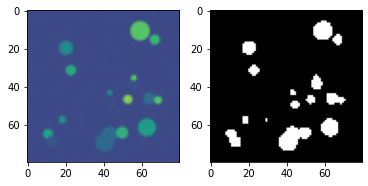

In [59]:
img, mask = train_ds[0]
plt.subplot(121)
plt.imshow(img.permute(1,2,0))
plt.subplot(122)
plt.imshow(mask, cmap='gray')
plt.show()

In [60]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

In [61]:
class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [62]:
class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=5,
                 start_filts=64, up_mode='transpose',
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

In [63]:


train_dl = DataLoader(train_ds,
                      batch_size=param.bs,
                      shuffle=True,
                      pin_memory=torch.cuda.is_available(),
                      num_workers=param.num_workers)
val_dl = DataLoader(test_ds,
                    batch_size=param.bs,
                    shuffle=False,
                    pin_memory=torch.cuda.is_available(),
                    num_workers=param.num_workers)

model = UNet(2,
             depth=param.unet_depth,
             start_filts=param.unet_start_filters,
             merge_mode='concat').cuda()
optim = torch.optim.Adam(model.parameters(), lr=param.lr)

<ipython-input-62-96850bffd297>:98: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
<ipython-input-62-96850bffd297>:99: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


In [64]:
def get_loss(dl, model):
    loss = 0
    for X, y in dl:
        X, y = Variable(X).cuda(), Variable(y).cuda()
        output = model(X)
        loss += F.cross_entropy(output, y).item()
    loss = loss / len(dl)
    return loss

In [65]:
iters = []
train_losses = []
val_losses = []

it = 0
min_loss = np.inf

model.train()
for epoch in range(param.epochs):
    for i, (X, y) in enumerate(train_dl):
        X = Variable(X).cuda()  # [N, 1, H, W]
        y = Variable(y).cuda()  # [N, H, W] with class indices (0, 1)
        output = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(output, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i + 1) % param.log_interval == 0:
            it += param.log_interval * param.bs
            iters.append(it)
            train_losses.append(loss.item())

            model.eval()
            val_loss = get_loss(val_dl, model)
            model.train()
            val_losses.append(val_loss)


model.eval()
val_loss = get_loss(val_dl, model)

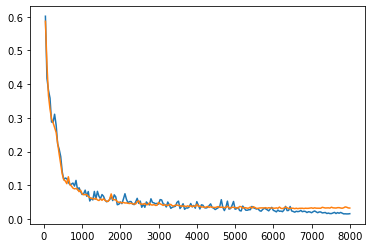

In [66]:
plt.plot(iters, train_losses)
plt.plot(iters, val_losses)
plt.show()

In [67]:
model.eval()
for X, masks in val_dl:
    X = X.cuda()
    output = model(X)
    break

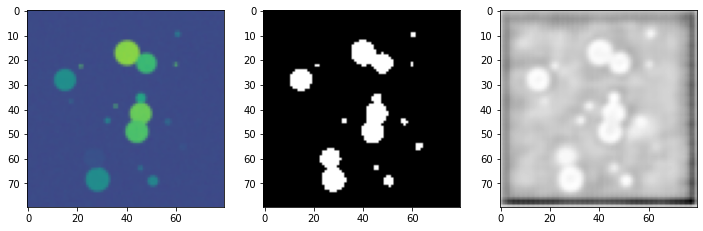

In [68]:
num_item = 5
image, mask, predicted = X[num_item],  masks[num_item], output[num_item, 1]
plt.figure(figsize=(12,4))
plt.subplot(131) 
plt.imshow(image.permute(1,2,0).cpu())
plt.subplot(132)
plt.imshow(mask.cpu(), cmap='gray')
plt.subplot(133)
plt.imshow(predicted.detach().cpu(), cmap='gray')
plt.show()